In [651]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr

In [2]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None, bounds=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0, "c": 1, "b": 0, "sigma": 1})
    if p0 is not None:
        fitter.set_p0(p0)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )
    
def gaussianC(f, f0, a, sigma, c): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) ) + c

def get_gaussianC_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussianC)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def two_peak_gaussian(f, f1, f2, a1, a2, sigma1, sigma2, b, c):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + c + b * f

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [3]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [4]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.5, "a": -0.1, "b": 0.0001, "c": np.average(antihole_normalized)}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in fits.keys():
            use_positive_stark_shift = label > 0
            if use_positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            p0["f_0"] = label * abs(headers["params"]["field_plate"]["stark_shift"].to("MHz").magnitude)
            antihole_fit: Fitter = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit: Fitter = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [5]:
def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        off_resonant_index_1 = 1
        off_resonant_index_2 = 0
        # off_resonant_index_2 = 1
        on_resonant_index_1 = 3
        on_resonant_index_2 = 2

        heights = {1: {}, -1: {}}
        backgrounds = {1: {}, -1: {}}

        heights[1]["ah"] = 1 - antihole_avg[on_resonant_index_1] / antihole_avg[off_resonant_index_1]
        heights[1]["rf"] = 1 - rf_avg[on_resonant_index_1] / rf_avg[off_resonant_index_1]
        heights[-1]["ah"] = 1 - antihole_avg[on_resonant_index_2] / antihole_avg[off_resonant_index_2]
        heights[-1]["rf"] = 1 - rf_avg[on_resonant_index_2] / rf_avg[off_resonant_index_2]

        backgrounds[1]["ah"] = antihole_avg[off_resonant_index_1]
        backgrounds[1]["rf"] = rf_avg[off_resonant_index_1]
        backgrounds[-1]["ah"] = antihole_avg[off_resonant_index_2]
        backgrounds[-1]["rf"] = rf_avg[off_resonant_index_2]
    return (heights, backgrounds)

In [6]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        try:
            transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
            if method == "auto":
                detunings_len = len(headers_single["detunings"])
                if detunings_len > 4:
                    method = "fit"
                else:
                    method = "ratio"
            if method == "fit":
                try:
                    fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
                except RuntimeError as e:
                    print(f"Fitting error for data number #{data_number}:")
                    raise e
                for label in fits:
                    if label not in rf_heights:
                        rf_heights[label] = []
                        antihole_heights[label] = []
                        rf_backgrounds[label] = []
                        antihole_backgrounds[label] = []
                    rf_heights[label].append(abs(fits[label]["rf"].results["a"]) / fits[label]["rf"].results["c"])
                    antihole_heights[label].append(abs(fits[label]["ah"].results["a"]) / fits[label]["ah"].results["c"])
                    rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                    antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
            elif method == "ratio":
                heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
                # heights, backgrounds = ah_parameters_from_data1(data_number)
                for label in heights:
                    if label not in rf_heights:
                        rf_heights[label] = []
                        antihole_heights[label] = []
                        rf_backgrounds[label] = []
                        antihole_backgrounds[label] = []
                    rf_heights[label].append(heights[label]["rf"])
                    antihole_heights[label].append(heights[label]["ah"])
                    rf_backgrounds[label].append(backgrounds[label]["rf"])
                    antihole_backgrounds[label].append(backgrounds[label]["ah"])
            headers.append(headers_single)
        except:
            continue
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

In [7]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

## Test HSH Pulse vs Sine Sweep

NameError: name 'data' is not defined

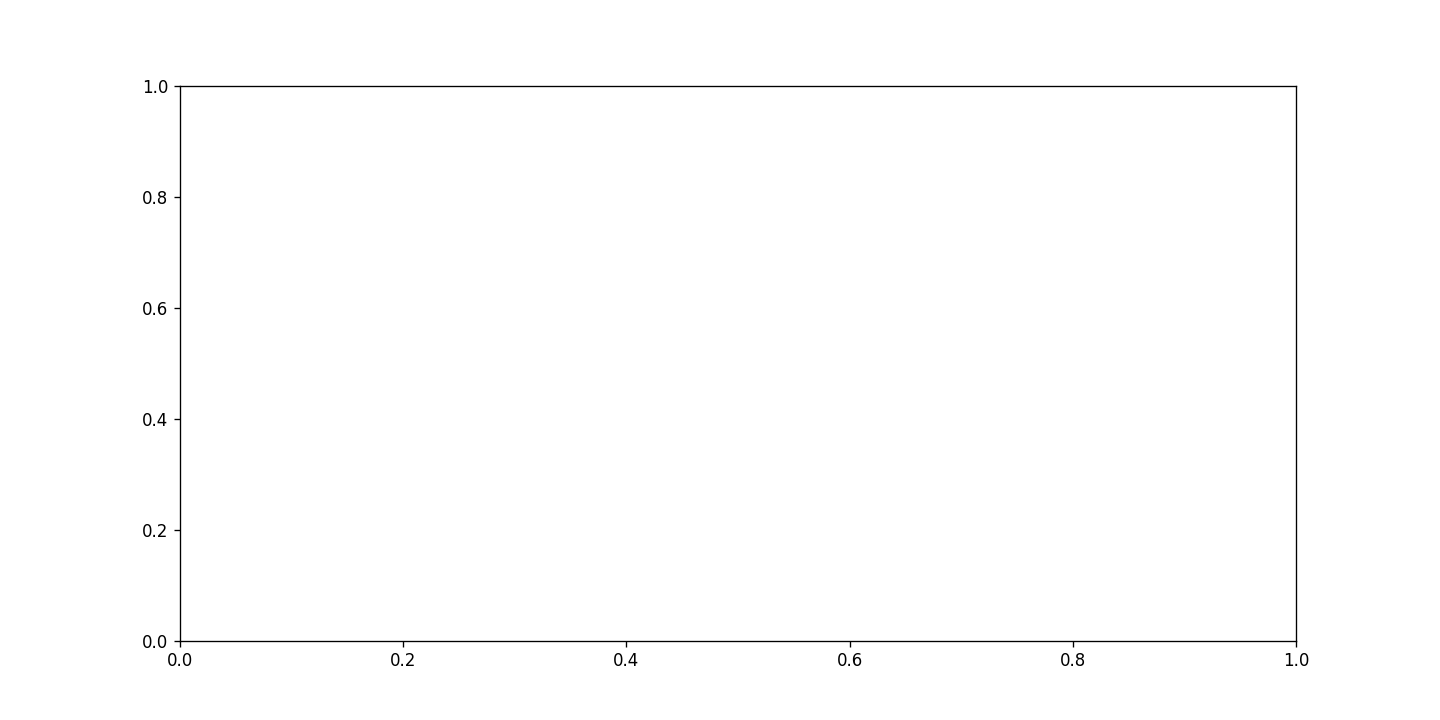

In [8]:
#data = {
    #"rf sweep": (328868, 328882), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    #"rf sweep 2": (329553, 329572),
    #"rf hsh 10 kHz scan range": (329204, 329223), # scan rf center_detuning from -200kHz to 200kHz. Each step has 10kHz scan
    #"rf hsh": (329224, 329243), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    #"rf hsh 2": (329533,329552),
#}

# data = { # comparing sine sweep with HSH pulse, averaged over 5 scans. 
#     "rf sweep": (329617, 329636), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
#     "rf sweep 2": (329637, 329656),
#     "rf sweep 3": (329657, 329676),
#     "rf sweep 4": (329677, 329696),
#     "rf sweep 5": (329697, 329716),
#     "rf hsh": (329717, 329736), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
#     "rf hsh 2": (329737, 329756),
#     "rf hsh 3": (329757, 329776),
#     "rf hsh 4": (329777, 329796),
#     "rf hsh 5": (329797, 329816),
# }


fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
sweeps = []
hsh_pulses = []
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["center_detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    if "sweep" in label:
        sweeps.append(ys)
    elif "hsh" in label:
        hsh_pulses.append(ys)
    #ax.scatter(xs, ys, label=label)

avg_sweep = np.mean(sweeps, axis = 0)
avg_hsh = np.mean(hsh_pulses, axis = 0)
ax.scatter(xs, avg_sweep, label = "avg sweep")
ax.scatter(xs, avg_hsh, label = "avg hsh")
ax.set_xlabel("RF HSH center detuning from the Zeeman transition average (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spectroscopy on b, bbar Transition

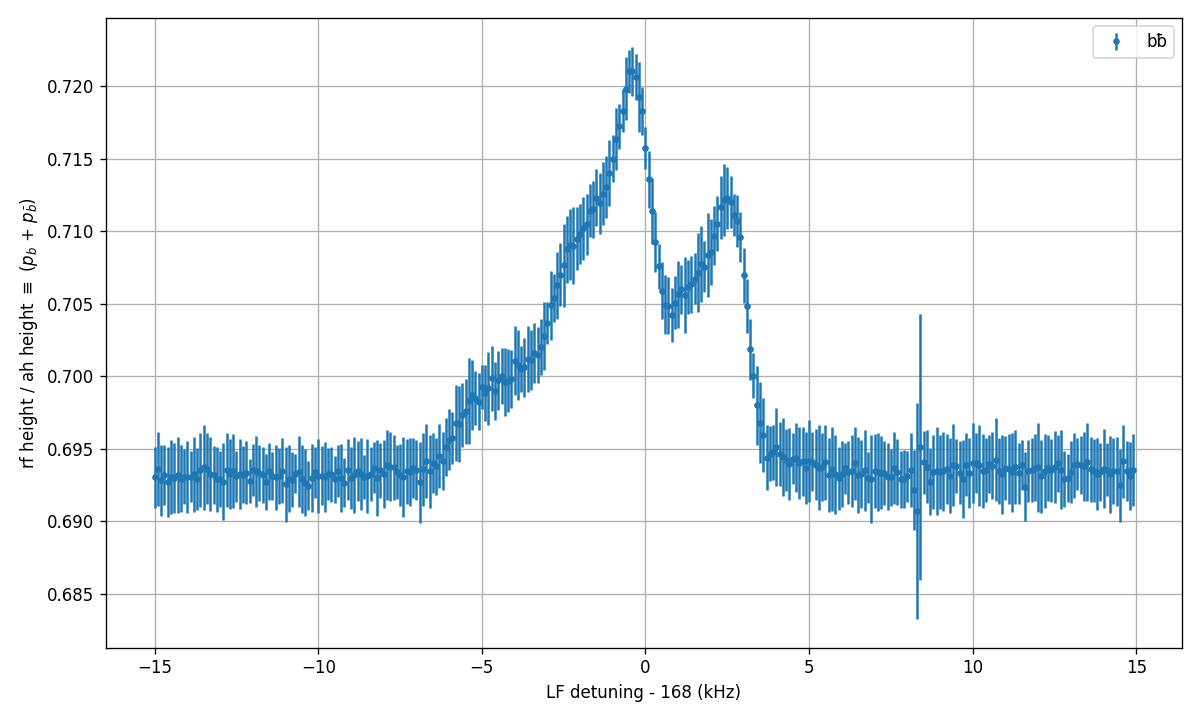

In [466]:
data = {
    "lf scan": (328888, 328927), # heating is an issue, nothing shows
    "lf scan, 1": (328928, 328967), # repeat of above
    "manual": (329029, 329066), # switch AWG for function generator
    "manual, 1": (329069, 329108), #repeat of above
    #"lf off": (329266,329384), # no lf, shows background due to heating
    #"lf scan, 2": (329385,329464) # same as first two
    #"lf scan with delays": (329817, 329896), # step size 0.5 kHz, 1 s delay between steps
    "lf scan with delay": (329897, 330056), # step size 0.25 kHz, 1 s delay between steps
    "lf scan prepare bbar": (330097, 330256)
}
data = {
    "rf test 0.3 ms, rf sweep off": (529783, 529812),
    "rf test 0.2 ms, rf sweep off": (529813, 529828),
    "rf test 0.5 ms, rf sweep off": (529829, 529839),
    "rf test 0.5 ms, rf sweep off, longer antihole": (529858, 529867),
    "rf test 0.5 ms, rf sweep off, antihole rf assist": (529871, 529900),
    "rf test 0.5 ms, rf sweep -110 to -10, antihole rf assist": (529901, 529930),
    "rf test 0.5 ms, rf sweep -110 to -10, antihole rf assist, repeat": (529946, 529975),
    "rf test 0.5 ms, rf sweep -80 to -40, antihole rf assist": (529976, 529990),
}
data = {
    #"lf test, 8000 amplitude, 30 ms": (530006, 530045),
    # "lf test, 8000 amplitude, 30 ms, broader": (530046, 530065),
    # "lf test, 2000 amplitude, 30 ms": (530066, 530085),
    # "lf test, 500 amplitude, 30 ms": (530086, 530105),
    # "lf test, 500 amplitude, 1 ms": (530106, 530125),
    # "lf test, 0 amplitude, 1 ms": (530126, 530145),
    #"lf test, 2000 amplitude, 0.1 ms": (530146, 530165),
    # "bƀ, 1000 amplitude, 0.1 ms": (530166, 530185),
    # "lf test, 1000 amplitude, 0.1 ms, repeat": (531319, 531338),
    #"lf test, 250 amplitude, 0.4 ms": (531339, 531405),
    #"lf test, 100 amplitude, 1 ms": (531406, 531472),
    #"lf test, 200 amplitude, 0.5 ms": (531473, 531539),
    #"lf test, 250 amplitude, 0.4 ms, after fridge stabilization": (531540, 531559),
    #"lf test, 150 amplitude, 0.4 ms": (531560, 531579),
    #"lf test, 125 amplitude, 0.4 ms": (531580, 531619),
    #"lf test, 125 amplitude, 0.4 ms sech": (531620, 531659),
    # "lf test, 125 amplitude, 0.4 ms sech, HSH": (531660, 531699),
    #"lf test, 50 amplitude, 0.4 ms sech, HSH": (531700, 531739),
    #"lf test, 90 amplitude, 0.7 ms sech, HSH": (531740, 531779),

    # "b lf test after code change -- start in b": (531948, 531967),
    # "a, 4000 amplitude, 305 kHz, 0.1 ms": (531968, 531987),
    # "aā, 4000 amplitude, 0.4 ms": (532098, 532111),
    # "aā, 2000 amplitude, 0.8 ms": (532112, 532131),

    # "bƀ, 30 amplitude, 2 ms": (532267, 532306),
    # "bƀ, 120 amplitude, 0.5 ms": (532307, 532316),
    # "bƀ, 60 amplitude, 1 ms": (532317, 532326),
    # "bƀ, 30 amplitude, 2 ms": (532327, 532336),

    
    # "bƀ, 60 amplitude, 1 ms - dense": (532338, 532367),
    # "bƀ, 60 amplitude, 1 ms - dense - again": (532368, 532397),
    # "bƀ, 60 amplitude, 1 ms - dense - flip": (532398, 532427),
    
    # "aā, 800 amplitude, 1 ms - dense": (532428, 532457),
    # "aā, 800 amplitude, 1 ms - dense - again": (532458, 532487),
    # "aā, 800 amplitude, 1 ms - dense - flip": (532488, 532517),
    
    # "aā, 800 amplitude - 1 ms": (532428, 532487),
    # "bƀ, 60 amplitude - 1 ms": (532338, 532427)

    # "test 12": (534351, 534362),
    # "test 13": (534363, 534374),

    ## DENSE
    # "bƀ, 60 amplitude - 1 ms 1": (535187, 535486),
    # "bƀ, 60 amplitude - 1 ms 2": (535487, 535786),
    # "bƀ, 60 amplitude - 1 ms 3": (535787, 536086),
    # "bƀ, 60 amplitude - 1 ms 4": (536087, 536386),
    # "bƀ, 60 amplitude - 1 ms 5": (536387, 536686),

    "bƀ": (535487, 538486)
    
}

# def averaging_ys(xs, ys):
#     xs_unique = np.unique(xs)
#     ys_to_avg = [[] for _ in range(len(xs_unique))]
#     for x, y in zip(xs, ys):
#         ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
#     ys_avg = []
#     for y_list in ys_to_avg:
#         ys_avg.append(np.average(y_list))
#     ys_avg = np.array(ys_avg)
    
#     return xs_unique, ys_avg
    

def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    ys_std = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
        ys_std.append(np.std(y_list))
    ys_avg = np.array(ys_avg)
    ys_std = np.array(ys_std)
    
    return xs_unique, ys_avg, ys_std
    

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    xs, ys, errs = averaging_ys(xs, ys)
    ax.errorbar(xs, ys, errs, label=label, marker='.', linestyle='')

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

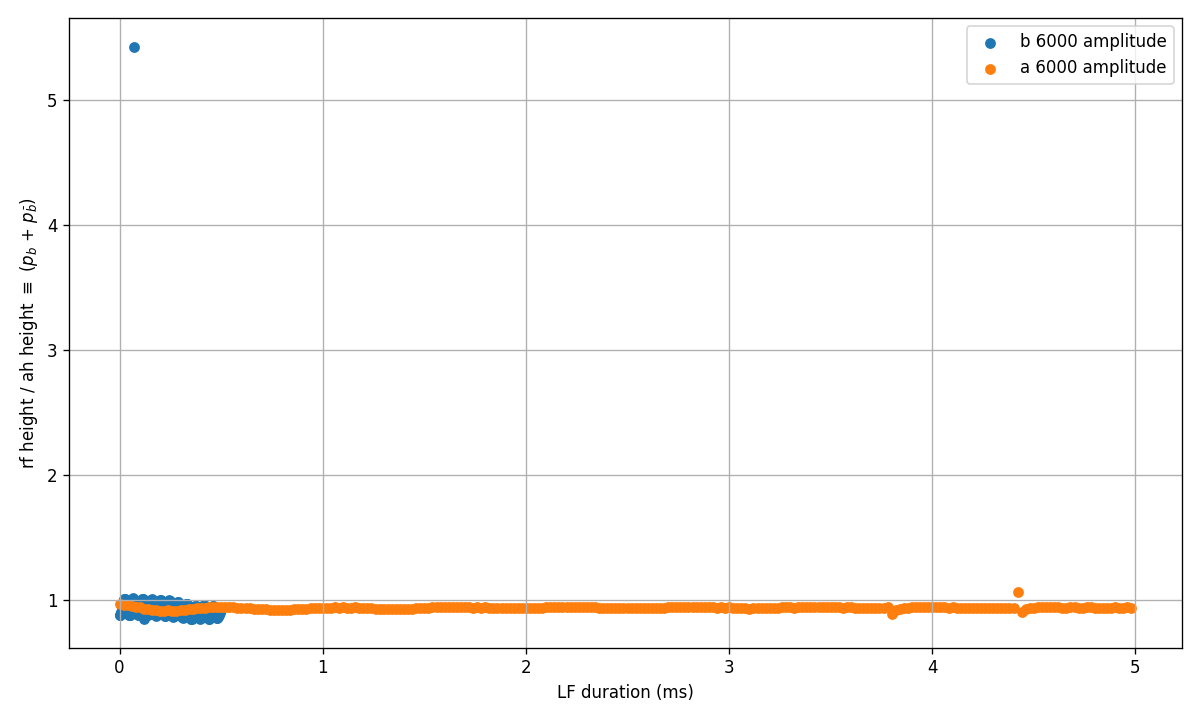

In [408]:
data = {
    # "lf 1000 amplitude": (530186, 530205),
    # "lf 8000 amplitude": (530226, 530245),
    # "b lf 8000 amplitude, shorter": (530266, 530285),
    # "lf 8000 amplitude, 1": (530396, 530396 + 922 - 1),

    # "aabar lf 4000 amplitude, 302 kHz": (531988, 532007),
    # "a lf 8000 amplitude, 302 kHz, longer": (532008, 532037),
    # "a lf 8000 amplitude, 302 kHz, longer, again": (532038, 532067),
    # "a lf 8000 amplitude, 302 kHz, longer, longer": (532068, 532097),
    
    # "a lf 800 amplitude": (532132, 532161),
    # "a lf 400 amplitude": (532162, 532191),
    # "b lf 40 amplitude": (532207, 532234),
    # "b lf 30 amplitude": (532237, 532266),
    
    # "b lf 6000 amplitude": (532788, 532822),
    "b 6000 amplitude": (533030, 533279),
    "a 6000 amplitude": (533280, 533529),
    # "b 6000 amplitude 2": (533530, 533779),
    # "b 6000 amplitude 3": (533780, 534029),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["duration"].to("ms").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spin Echo bbbar

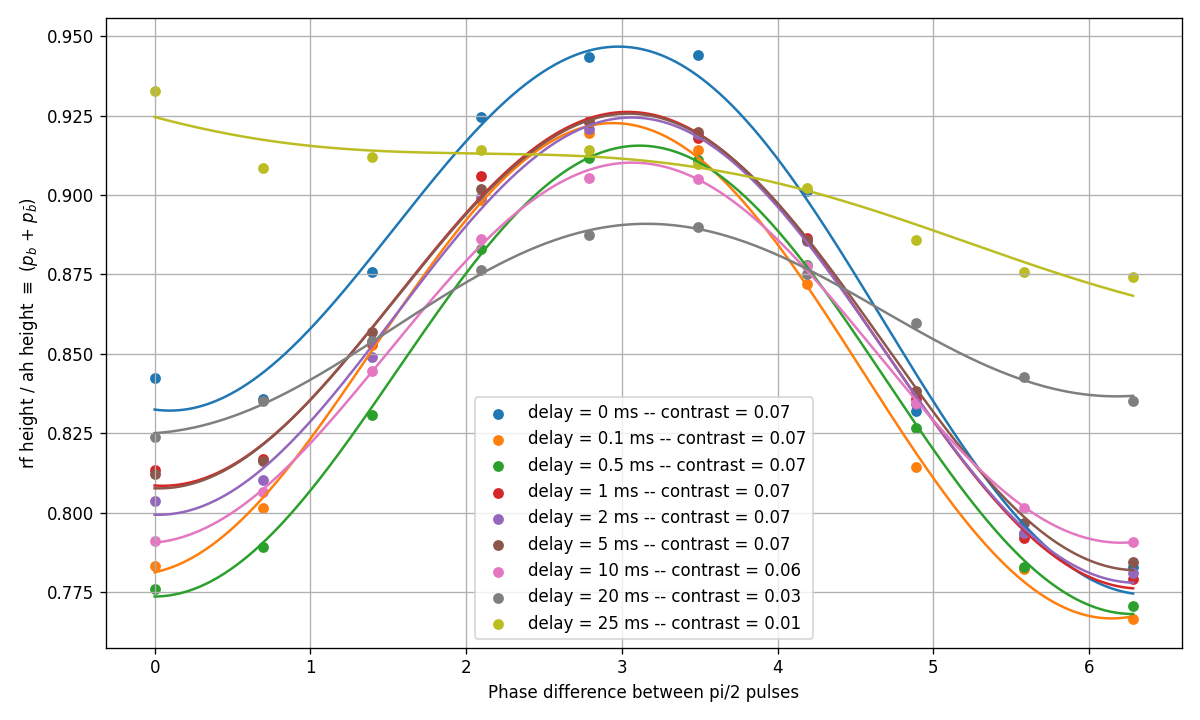

In [330]:
def sine_func(phi, a, theta, b, c) :
    return a * np.sin(phi + theta) + b*phi + c

def sineFit(xs, ys):
    fitter = Fitter(sine_func)
    fitter.set_absolute_sigma(False)
    fitter.set_data(xs, ys)
    fitter.fit(maxfev = 10000)
    return fitter

data = {
    # "6000 amplitude, 0.025 ms pi time, 0 ms delay": (532828, 532837),
    "6000 amplitude, 0.025 ms pi time, 0 ms delay": (532838, 532847),
    "6000 amplitude, 0.025 ms pi time, 0.1 ms delay": (532848, 532857),
    "6000 amplitude, 0.025 ms pi time, 0.5 ms delay": (532858, 532867),
    "6000 amplitude, 0.025 ms pi time, 1 ms delay": (532868, 532877),
    "6000 amplitude, 0.025 ms pi time, 2 ms delay": (532878, 532887),
    "6000 amplitude, 0.025 ms pi time, 5 ms delay": (532888, 532897),
    "6000 amplitude, 0.025 ms pi time, 10 ms delay": (532898, 532907),
    "6000 amplitude, 0.025 ms pi time, 20 ms delay": (532908, 532917),
    "6000 amplitude, 0.025 ms pi time, 25 ms delay": (532918, 532927),
}

contrasts_b = []
delays_b = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["phase"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    
    gaussian_fit = sineFit(xs, ys)
    xs_fit = np.linspace(np.min(xs), np.max(xs), 1000)
    ax.plot(xs_fit, gaussian_fit.fitted_value(xs_fit))

    contrast = abs(gaussian_fit.results["a"])
    delay = headers[0]["params"]["lf"]["delay_time"].to("ms").magnitude
    
    contrasts_b.append(contrast)
    delays_b.append(delay)
    
    ax.scatter(xs, ys, label=f"delay = {delay} ms -- contrast = {contrast:.2f}", s = 30)


ax.set_xlabel(f"Phase difference between pi/2 pulses")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spin Echo aabar

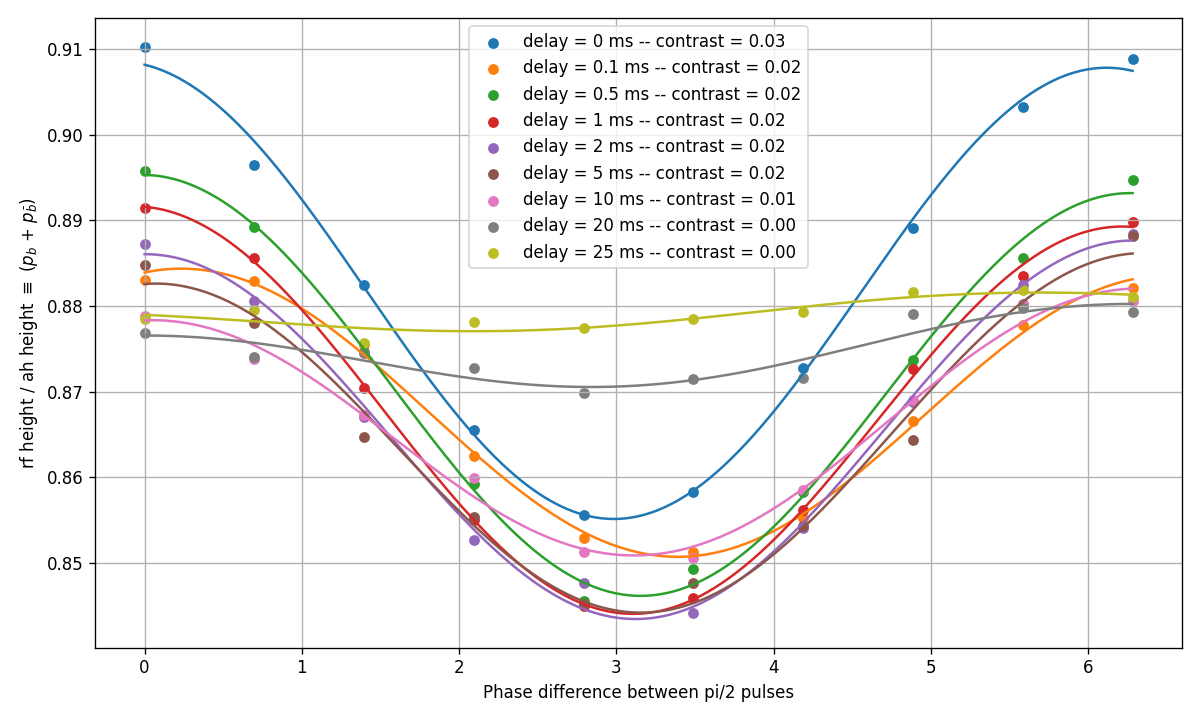

In [331]:
data = {
    # "6000 amplitude, 0.33 ms pi time, 0 ms delay": (532928, 532937),
    "6000 amplitude, 0.33 ms pi time, 0 ms delay": (532938, 532947),
    "6000 amplitude, 0.33 ms pi time, 0.1 ms delay": (532948, 532957),
    "6000 amplitude, 0.33 ms pi time, 0.5 ms delay": (532958, 532967),
    "6000 amplitude, 0.33 ms pi time, 1 ms delay": (532968, 532977),
    "6000 amplitude, 0.33 ms pi time, 2 ms delay": (532978, 532987),
    "6000 amplitude, 0.33 ms pi time, 5 ms delay": (532988, 532997),
    "6000 amplitude, 0.33 ms pi time, 10 ms delay": (532998, 533007),
    "6000 amplitude, 0.33 ms pi time, 20 ms delay": (533008, 533017),
    "6000 amplitude, 0.33 ms pi time, 25 ms delay": (533018, 533027),
}

contrasts_a = []
delays_a = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["phase"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    
    gaussian_fit = sineFit(xs, ys)
    xs_fit = np.linspace(np.min(xs), np.max(xs), 1000)
    ax.plot(xs_fit, gaussian_fit.fitted_value(xs_fit))

    contrast = abs(gaussian_fit.results["a"])
    delay = headers[0]["params"]["lf"]["delay_time"].to("ms").magnitude
    
    contrasts_a.append(contrast)
    delays_a.append(delay)
    
    ax.scatter(xs, ys, label=f"delay = {delay} ms -- contrast = {contrast:.2f}", s = 30)


ax.set_xlabel(f"Phase difference between pi/2 pulses")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

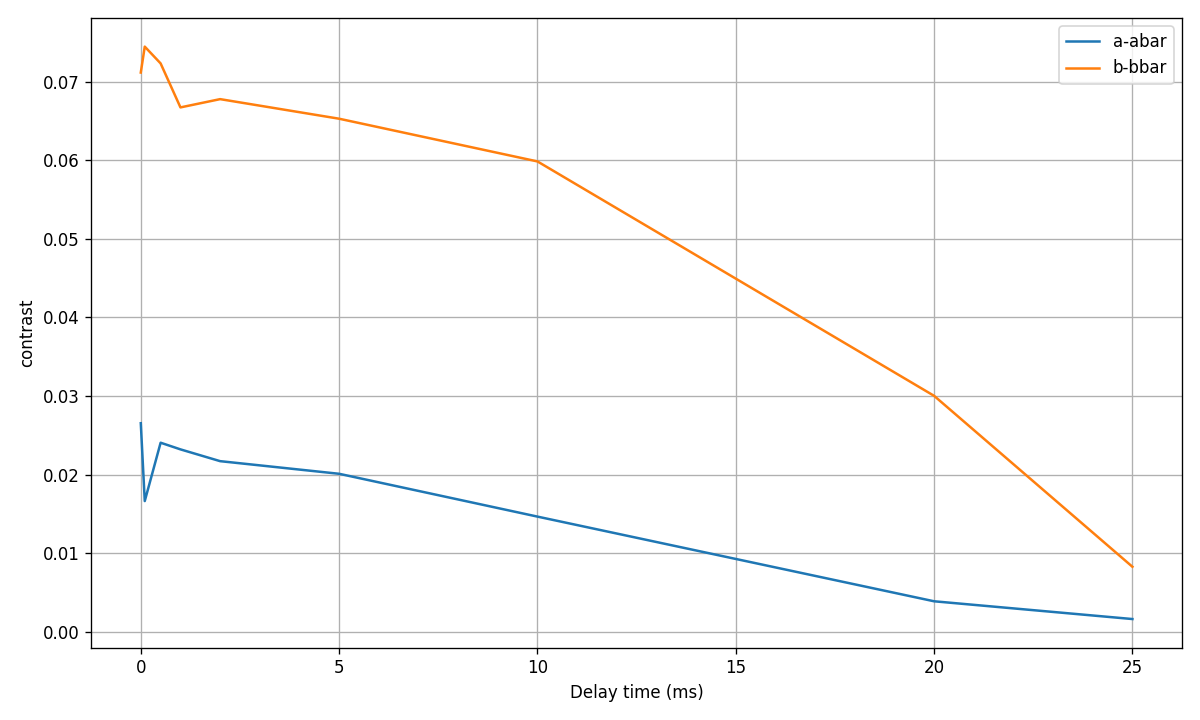

In [333]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
ax.plot(delays_a, contrasts_a, label="a-abar")
ax.plot(delays_b, contrasts_b, label="b-bbar")
ax.set_xlabel(f"Delay time (ms)")
ax.set_ylabel("contrast")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Hole and AOM only

In [221]:
from onix.units import ureg

def get_average_heights(data_number):
    data, headers = get_experiment_data(data_number)

    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    
    plt_monitor = True
    use_positive = None
    
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        chasm_avg = None
        antihole_normalized = antihole_avg / monitors_avg["antihole"]
        rf_normalized = rf_avg / monitors_avg["rf"]
    
    if headers["params"]["field_plate"]["use"]:
        hat_E = headers["params"]["field_plate"]["amplitude"] > 0
        hat_probe = headers["params"]["field_plate"]["stark_shift"] > 0
        mask = detunings_MHz > 0
        mask1 = detunings_MHz < 0
        return np.array([
            np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])
        ]), np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), headers, (hat_E, hat_probe)
    else:
        return np.average(antihole_normalized), np.average(rf_normalized), headers, None

def get_voltage_ratios(data_list):
    ratios = []
    headers = []
    E_fields = []
    for kk in data_list:
        h1, h2, header, E_field = get_average_heights(kk)
        ratios.append(h2 / h1)
        headers.append(header)
        E_fields.append(E_field)
    return np.array(ratios), headers, E_fields

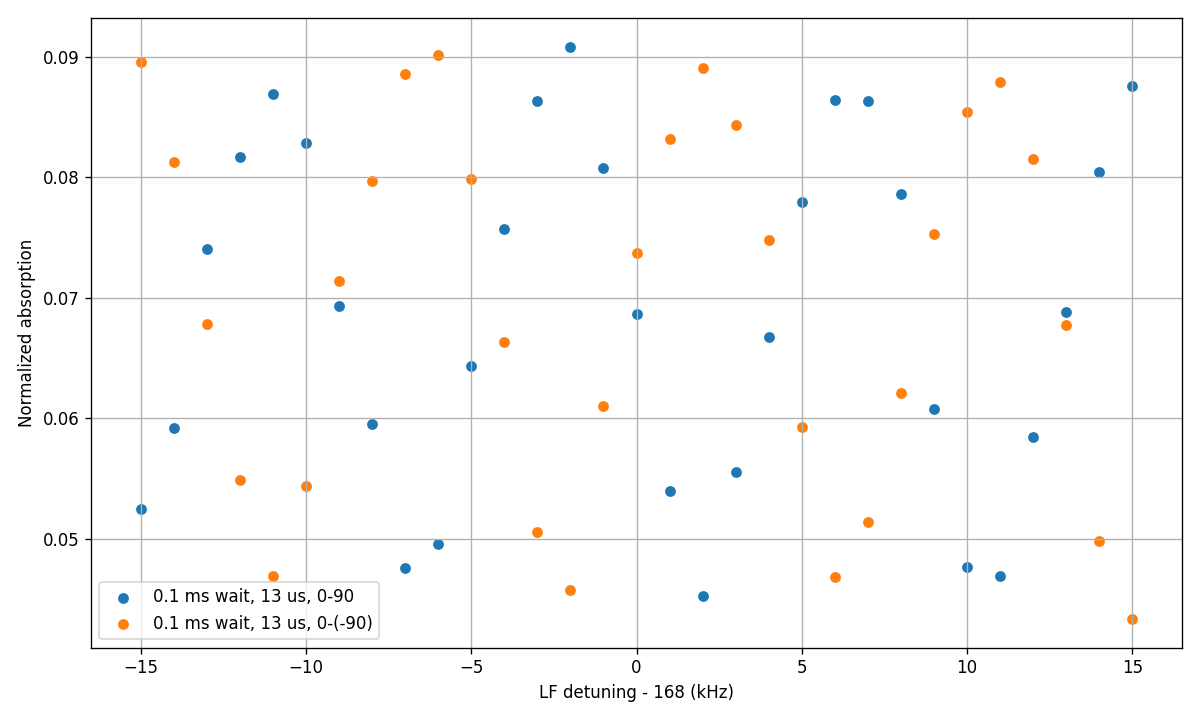

In [459]:
data = {
    #"b-bbar": (534491, 534502),
    # "b-bbar, 1": (534503, 534514),
    # "b-bbar, 2": (534572, 534583),
    # "b-bbar, less chasm": (534584, 534595),
    # "b-bbar, same less chasm, longer cb": (534596, 534602),
    # "b-bbar, more rf repeats": (534603, 534614),
    # "b-bbar, even more rf repeats": (534615, 534626),
    # "b-bbar, shorter optical, longer rf, less repeats": (534627, 534638),
    # "b-bbar, longer optical, longer rf, less repeats": (534639, 534650),
    #"b-bbar, 1 ms": (538714, 538733),
    #"b-bbar, 1 ms, 1": (538734, 538800),
    #"b-bbar, 1 ms, 2": (538801, 538840),
    "b-bbar, 1 ms, moved beam up": (539197, 539263),
    "b-bbar, 1 ms, moved beam up, RF sweep 5 kHz": (539264, 539330),
    "b-bbar, 1 ms, moved beam up, 1": (539334, 539400),
    "b-bbar, 1 ms, moved beam up and then left": (539401, 539467),
    "b-bbar, 1 ms, moved beam up and then left, probe awg 400": (539468, 539534),
    
}

data = {
    # ramsey data
    "0.1 ms wait, 13 us, 0-90": (579254, 579284),
    "0.1 ms wait, 13 us, 0-(-90)": (579285, 579315),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios)
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

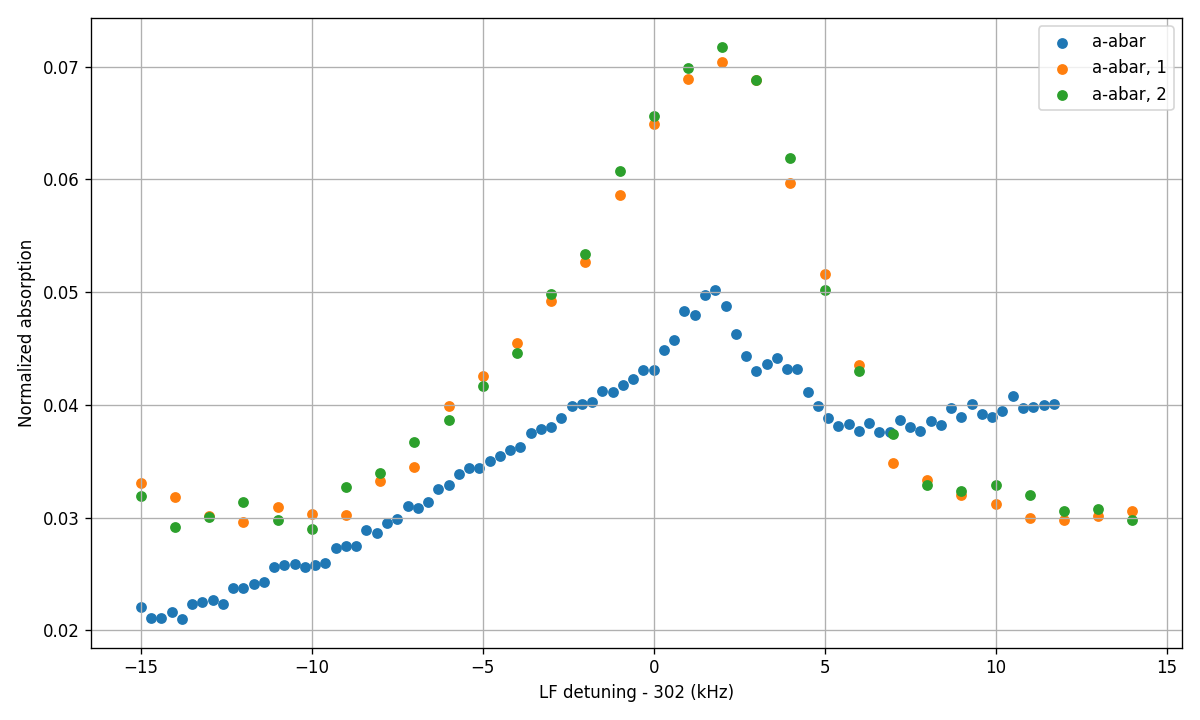

In [217]:
data = {
    "a-abar": (538863, 538952),
    "a-abar, 1": (539642, 539671),
    "a-abar, 2": (539672, 539701),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = 1-ratios
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

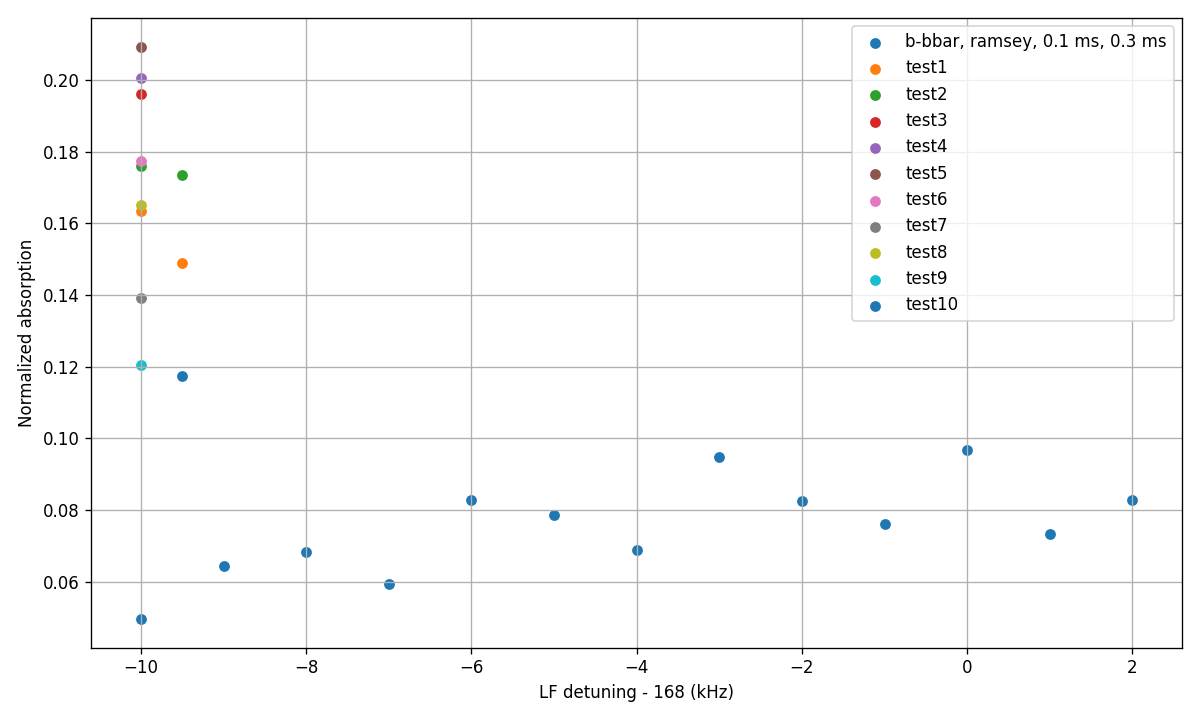

In [218]:
data = {
    "b-bbar, ramsey, 0.1 ms, 0.3 ms": (539535, 539547),
    "test1": (539555, 539556),
    "test2": (539557, 539558),
    "test3": 539559,
    "test4": 539560,
    "test5": 539564,
    "test6": 539566,
    "test7": 539568,
    "test8": 539570,
    "test9": 539581,
    "test10": 539641,
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios)
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

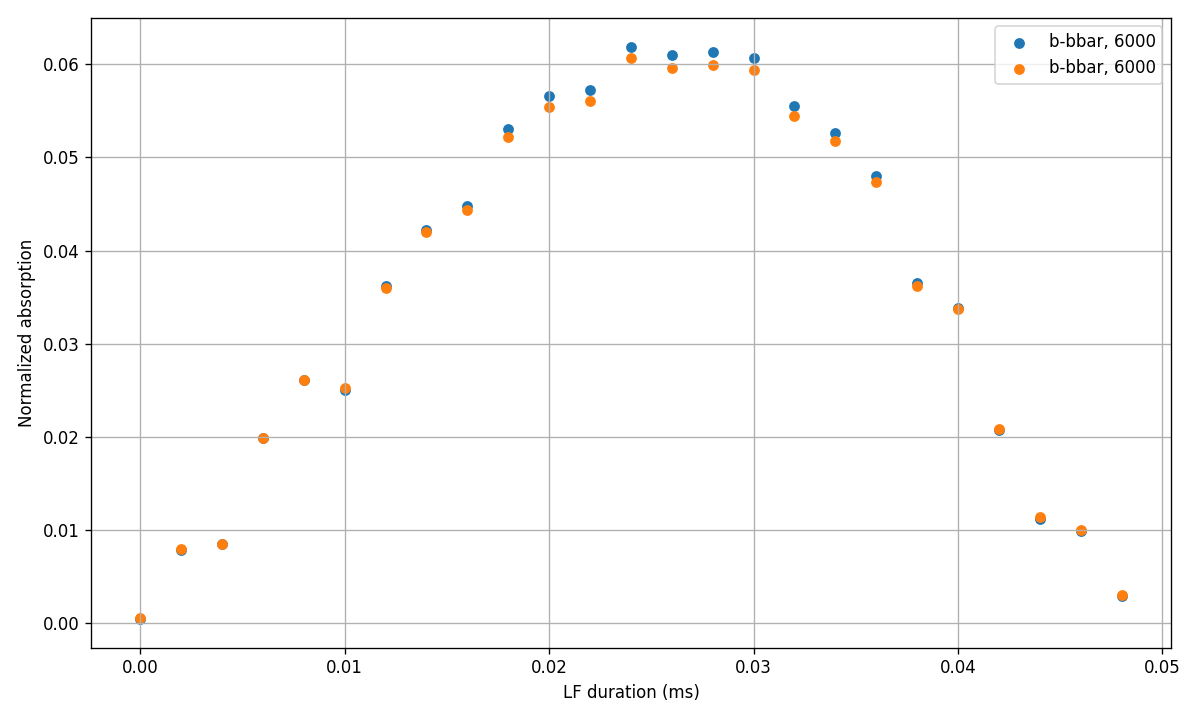

In [457]:
data = {
    "b-bbar, 6000": (579673, 579697),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["duration"].to("ms").magnitude for header in headers]
    ys = (1-ratios)
    ax.scatter(xs, ys[:, 0], label=label, s = 30)
    ax.scatter(xs, ys[:, 1], label=label, s = 30)

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Time-series

In [364]:
def get_lorentzian_fit(detunings, voltages, p0=None, bounds=None):
    def lorentzian(f, f_0, gamma, a, c):
        return (gamma / 2) / ((f - f_0) ** 2 + gamma ** 2 / 4) * a + c
    fitter = Fitter(lorentzian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0.001, "c": 0.001, "gamma": 1, "a": 1})
    if p0 is not None:
        fitter.set_p0(p0)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

f_0 = -0.24(13) True
f_0 = -0.20(14) False

f_0 = 2.5(4) True
f_0 = 2.5(4) False



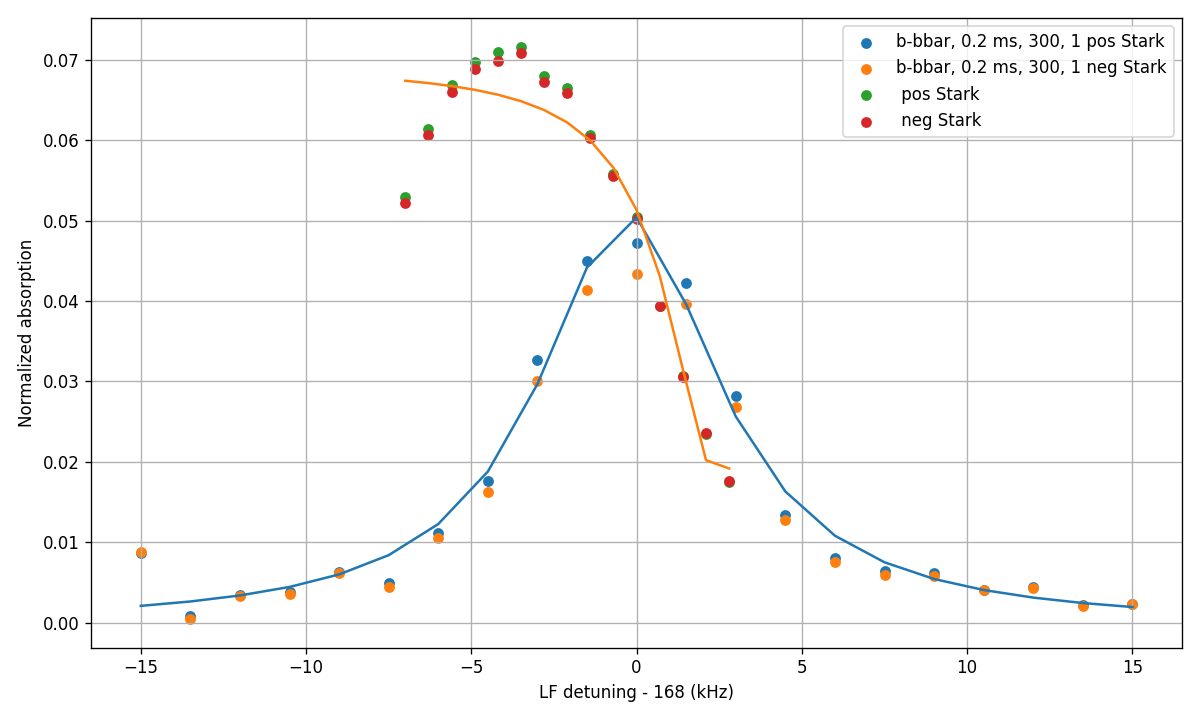

In [513]:
data = {
    "b-bbar, 0.2 ms, 300, 1": (553422, 553442),  # original parameters
    # "b-bbar, 0.2 ms, 300, 2": (553443, 553463),
    # "b-bbar, 0.2 ms, 300, 3": (553464, 553484),
    # "b-bbar, 0.2 ms, 300, 4": (553485, 553505),
    # "b-bbar, 0.2 ms, 300, 1": (553506, 553526),  # negative Stark shift
    # "b-bbar, 0.2 ms, 300, 2": (553527, 553547),
    # "b-bbar, 0.2 ms, 300, 3": (553548, 553568),
    # "b-bbar, 0.2 ms, 300, 1": (553578, 553598),  # 5x longer chasms
    # "b-bbar, 0.2 ms, 300, 2": (553599, 553619),
    # "b-bbar, 0.2 ms, 300, 3": (553620, 553640),
    # "b-bbar, 0.2 ms, 300, 4": (553641, 553661),
    # "b-bbar, 0.2 ms, 300, 1": (553665, 553685),  # RF sweep 3x longer, this seems to eliminate the offset
    # "b-bbar, 0.2 ms, 300, 2": (553686, 553706),
    # "b-bbar, 0.2 ms, 300, 3": (553707, 553727),
    # "b-bbar, 0.2 ms, 300, 4": (553728, 553748),
    # "b-bbar, 0.2 ms, 300, 5": (553749, 553769),
    # "b-bbar, 0.2 ms, 300, 6": (553770, 553790),
    # "b-bbar, 0.2 ms, 300, 7": (553791, 553811),
    # "b-bbar, 0.2 ms, 300, 8": (553812, 553832),
    # "b-bbar, 0.2 ms, 300, 1": (553833, 553853),  # back to the original params
    # "b-bbar, 0.2 ms, 300, 2": (553854, 553874),
    # "b-bbar, 0.2 ms, 300, 3": (553875, 553895),
    # "b-bbar, 0.2 ms, 300, 4": (553896, 553916),
    # "b-bbar, 0.2 ms, 300, 1": (553919, 553939),  # ao center frequency -3 MHz
    # "b-bbar, 0.2 ms, 300, 2": (553940, 553960),
    # "b-bbar, 0.2 ms, 300, 3": (553961, 553981),
    # "b-bbar, 0.2 ms, 300, 4": (553982, 554002),
    # "b-bbar, 0.2 ms, 300, 1": (554006, 554026),  # RF sweep 3x longer again
    # "b-bbar, 0.2 ms, 300, 2": (554027, 554047),
    # "b-bbar, 0.2 ms, 300, 3": (554048, 554068),
    # "b-bbar, 0.2 ms, 300, 4": (554069, 554089),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        pos_fit = get_lorentzian_fit(xs, ys[:,0])
        print(pos_fit.result_str("f_0"), E_field[0][0] == E_field[0][1])
        ax.plot(xs, pos_fit.fitted_value(xs))
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
        neg_fit = get_lorentzian_fit(xs, ys[:,1])
        print(neg_fit.result_str("f_0"), E_field[0][0] != E_field[0][1])
        print()

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [491]:
data = {
    "b-bbar, 0.2 ms, 300, 1": (539925, 539945),  # 10 ms RF
    "b-bbar, 0.2 ms, 300, 2": (539946, 539966),
    "b-bbar, 0.2 ms, 300, 3": (539967, 539987),
    "b-bbar, 0.2 ms, 300, 4": (539988, 540008),
}
data = {
    "b-bbar, 0.2 ms, 300, 1": (554006, 554026),  # 30 ms RF
    "b-bbar, 0.2 ms, 300, 2": (554027, 554047),
    "b-bbar, 0.2 ms, 300, 3": (554048, 554068),
    "b-bbar, 0.2 ms, 300, 4": (554069, 554089),
}
max = 558500
fs = {}

for kk in data:
    fs[kk] = []

current = data[list(data.keys())[0]][1]
offset = 0
while current + offset <= max:
    for ll, (label, data_range) in enumerate(data.items()):
        data_range = (data_range[0] + offset, data_range[1] + offset)
        data_list = data_identification_to_list(data_range)
        ratios, headers, E_field = get_voltage_ratios(data_list)
        xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
        ys = (1-ratios)
        if E_field[0] is not None:
            # ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
            pos_fit = get_lorentzian_fit(xs, ys[:,0])
            #ax.plot(xs, pos_fit.fitted_value(xs))
            #print(pos_fit.all_results_str())
            # ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
            neg_fit = get_lorentzian_fit(xs, ys[:,1])
            fs[label].append([pos_fit, neg_fit])
    offset += 21 * 4

In [492]:
f1 = []
f2 = []
for kk in range(len(fs['b-bbar, 0.2 ms, 300, 1'])):
    for label in fs:
        if int(label[-1]) % 2 == 3:
            continue
        if int(label[-1]) <= 2:
            f1.append(ufloat(fs[label][kk][0].results["f_0"], fs[label][kk][0].errors["f_0"]))
            f2.append(ufloat(fs[label][kk][1].results["f_0"], fs[label][kk][1].errors["f_0"]))
        else:
            f1.append(ufloat(fs[label][kk][1].results["f_0"], fs[label][kk][1].errors["f_0"]))
            f2.append(ufloat(fs[label][kk][0].results["f_0"], fs[label][kk][0].errors["f_0"]))
f1 = np.array(f1)
f2 = np.array(f2)

-0.1247877811843141 0.01305001659124386
-0.11287166474074418 0.013454503109024726
0.0007821162333136271


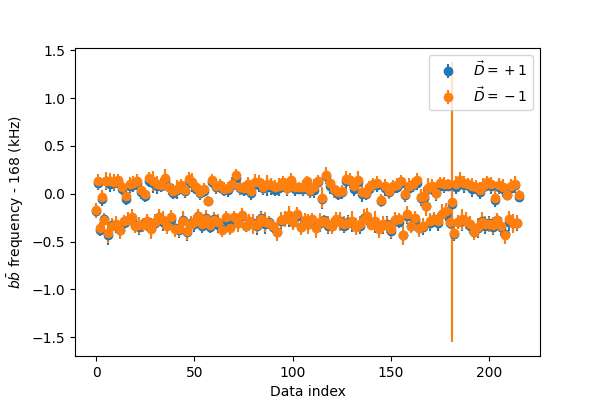

In [493]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(f1)), unumpy.nominal_values(f1), unumpy.std_devs(f1), fmt="o", label="$\\vec{D}=+1$")
print(np.average(unumpy.nominal_values(f1)), np.std(unumpy.nominal_values(f1)) / np.sqrt(len(f1)))
ax.errorbar(np.arange(len(f2)), unumpy.nominal_values(f2), unumpy.std_devs(f2), fmt="o", label="$\\vec{D}=-1$")
print(np.average(unumpy.nominal_values(f2)), np.std(unumpy.nominal_values(f2)) / np.sqrt(len(f2)))
print(np.std(unumpy.nominal_values(f1 - f2)) / np.sqrt(len(f2)))
ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency - 168 (kHz)")
ax.legend()
plt.show()

## Time-series Ramsey

In [446]:
def get_sine_fit(detunings, voltages, p0=None, bounds=None):
    def sine(f, f_0, t, a, c):
        return np.sin(2*np.pi*(f - f_0) * t) * a + c
    fitter = Fitter(sine)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0.001, "c": np.average(voltages), "t": 0.1, "a": (np.max(voltages) - np.min(voltages)) / 2})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.set_bounds("f_0", -1, 1)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

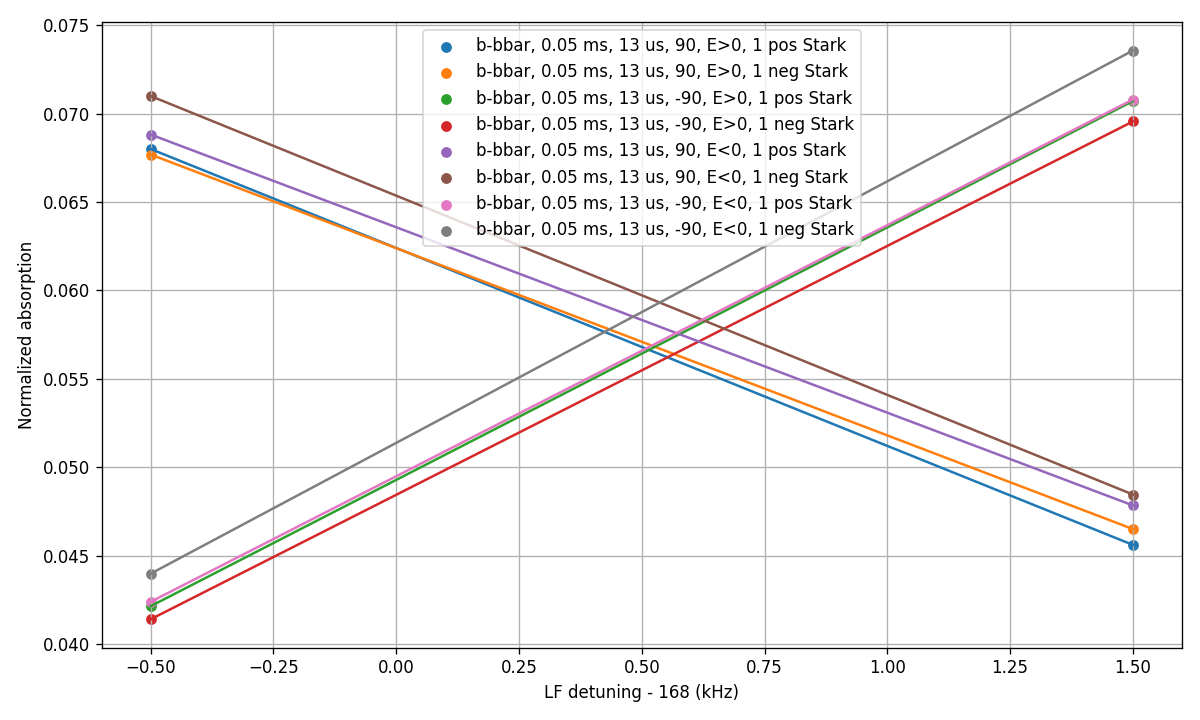

In [629]:
data = {
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (579736, 579755),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (579756, 579775),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (579776, 579795),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (579796, 579815),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 1": (579816, 579835),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 1": (579836, 579855),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 1": (579856, 579875),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 1": (579876, 579895),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 2": (580066, 580085),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 2": (580086, 580105),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 2": (580106, 580125),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 2": (580126, 580145),

    
    # "new params": (580680, 580699),
    # "new params 2": (580700, 580719),

    # "longer averaging": (580734, 580753),
    # "longer averaging 2": (580754, 580773),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (581177, 581178),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (581179, 581180),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (581181, 581182),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (581183, 581184),
    "b-bbar, 0.05 ms, 13 us, 90, E>0, 1": (581290, 581291),
    "b-bbar, 0.05 ms, 13 us, -90, E>0, 1": (581292, 581293),
    "b-bbar, 0.05 ms, 13 us, 90, E<0, 1": (581294, 581295),
    "b-bbar, 0.05 ms, 13 us, -90, E<0, 1": (581296, 581297),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 2": (581830, 581831),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 2": (581832, 581833),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 2": (581834, 581835),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 2": (581836, 581837),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 3": (582214, 582215),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 3": (582216, 582217),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 3": (582218, 582219),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 3": (582220, 582221),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        pos_fit = get_sine_fit(xs, ys[:, 0])
        ax.plot(xs, pos_fit.fitted_value(xs))
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
        neg_fit = get_sine_fit(xs, ys[:, 1])
        ax.plot(xs, neg_fit.fitted_value(xs))

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [598]:
data = {
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (579736, 579755),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (579756, 579775),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (579776, 579795),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (579796, 579815),
    
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (580066, 580085),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (580086, 580105),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (580106, 580125),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (580126, 580145),

    
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (580734, 580753),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (580754, 580773),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (580774, 580793),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (580794, 580813),

    
    "b-bbar, 0.05 ms, 13 us, 90, E>0": (581218, 581219),
    "b-bbar, 0.05 ms, 13 us, -90, E>0": (581220, 581221),
    "b-bbar, 0.05 ms, 13 us, 90, E<0": (581222, 581223),
    "b-bbar, 0.05 ms, 13 us, -90, E<0": (581224, 581225),
}
max = 588206
fs = {}
f1 = []
f2 = []

for kk in data:
    fs[kk] = []

current = data[list(data.keys())[-1]][1]
offset = 0
while current + offset <= max:
    for ll, (label, data_range) in enumerate(data.items()):
        if ll % 2 == 1:
            continue
        data_range_1 = (data_range[0] + offset, data_range[1] + offset)
        data_list = data_identification_to_list(data_range_1)
        ratios, headers, E_field = get_voltage_ratios(data_list)
        xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
        ys = (1-ratios)
        data_range_1 = (data_range[0] + offset + 2, data_range[1] + offset + 2)
        data_list = data_identification_to_list(data_range_1)
        ratios, headers, E_field = get_voltage_ratios(data_list)
        y1s = (1-ratios)
        for kk in range(2):
            y1 = ys[0][kk]
            y2 = y1s[1][kk]
            y3 = y1s[0][kk]
            y4 = ys[1][kk]
            # h1 = abs(ys[0][kk] - y1s[0][kk])
            # h2 = abs(ys[1][kk] - y1s[1][kk])
            if kk == 0:
                #f1.append(xs[0] + 2 * h1 / (h1 + h2))
                f1.append((y4 + y1 - y2 - y3) / (y2 - y3 - y4 + y1) + xs[1] + 1)
            else:
                #f2.append(xs[0] + 2 * h1 / (h1 + h2))
                f2.append((y4 + y1 - y2 - y3) / (y2 - y3 - y4 + y1) + xs[1] + 1)
    offset += 2 * 4

f1 = np.array(f1)
f2 = np.array(f2)

f_plus = 0.4386 +/- 0.0020 kHz
f_minus = 0.4352 +/- 0.0020 kHz
f_plus - f_minus = 0.0034 +/- 0.0011 kHz


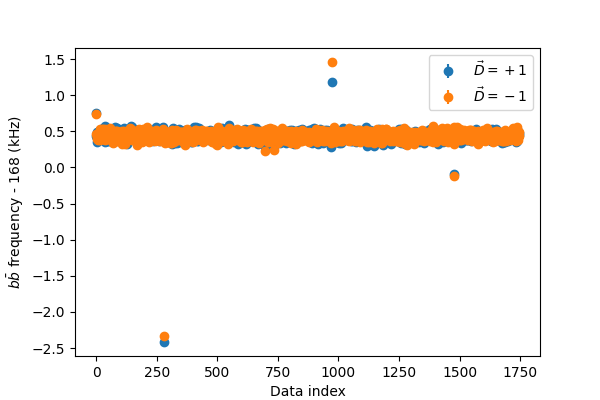

In [624]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(f1)), unumpy.nominal_values(f1), unumpy.std_devs(f1), fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(np.arange(len(f2)), unumpy.nominal_values(f2), unumpy.std_devs(f2), fmt="o", label="$\\vec{D}=-1$")


ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency - 168 (kHz)")
ax.legend()
plt.show()

# June 25, 2024
changes since last analysis:
- taking 4 data points for the ramsey spectroscopy

to do by friday:
- is there an algebraic equation that minimizes the uncertainty of the line center using 4 measurements?
- time domain trend line
- expand beam size to check with fluctuations
      - check current beam size w/ beam profiler
      - 2 mm diameter for 3 x 4 mm cyrstal
- look for trend in the normalized absorption w/ the same parameters in LF ramsey
- take less averages (AWG fix)
- improve duty cycle
- maximize RF rabi frequency with RF resonance tuning
      

820
f_plus = 0.4386 +/- 0.0020 kHz
f_minus = 0.4352 +/- 0.0020 kHz
f_plus - f_minus = 0.0034 +/- 0.0011 kHz


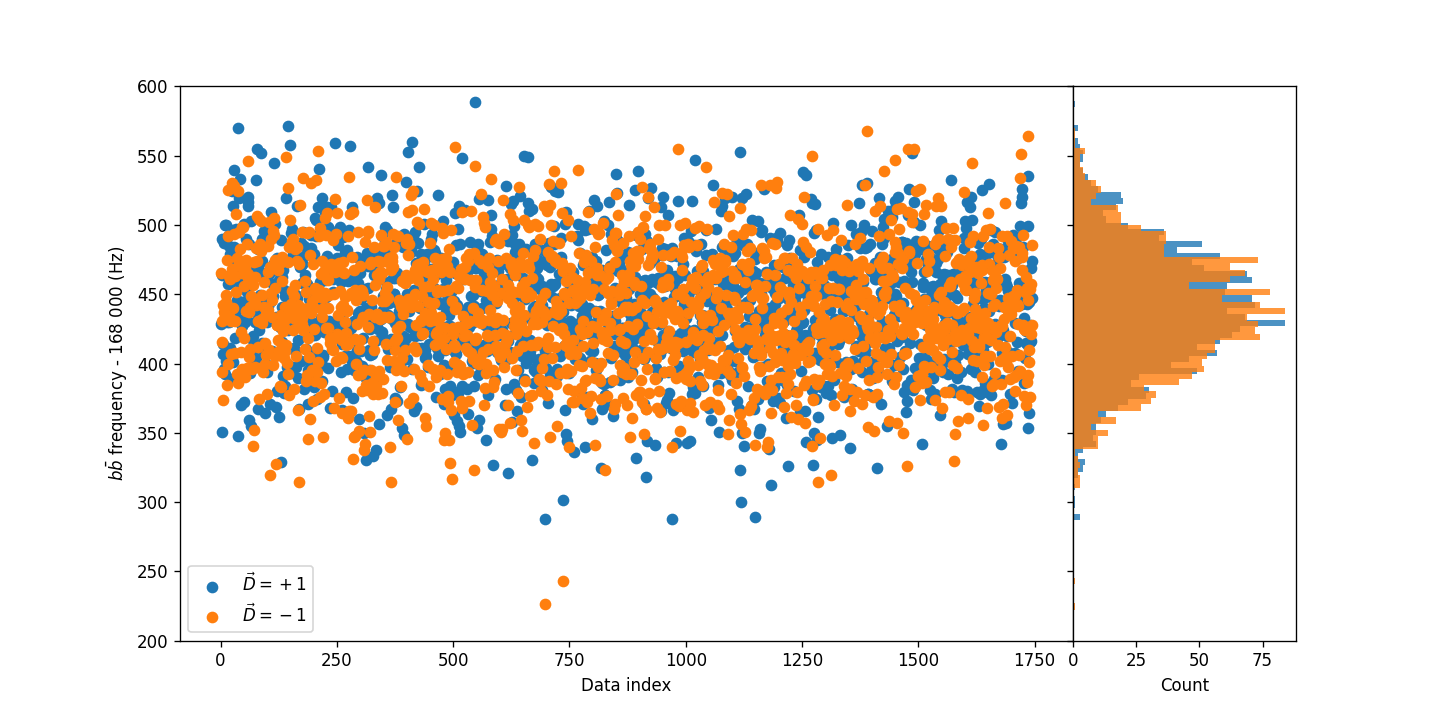

In [652]:
xs1 = np.arange(len(f1))
ys1 = unumpy.nominal_values(f1)
ys1_err = unumpy.std_devs(f1)

xs2 = np.arange(len(f2))
ys2 = unumpy.nominal_values(f2)
ys2_err = unumpy.std_devs(f2)

n_bins = int(np.sqrt(len(f1))) * 20
print(n_bins)
bins_alpha = 0.8

fig, axs = plt.subplots(1, 2, figsize = (12, 6), dpi = 120, sharey='row', sharex='col', gridspec_kw={'width_ratios': [4, 1]})
axs[0].scatter(xs1, ys1*1000., label="$\\vec{D}=+1$")
_ = axs[1].hist(ys1*1000., bins=n_bins, orientation='horizontal', alpha=bins_alpha)
# axs[0].plot([np.min(xs1), np.max(xs1)], [np.average(ys1), np.average(ys1)])

axs[0].scatter(xs2, ys2*1000., label="$\\vec{D}=-1$")
_ = axs[1].hist(ys2*1000., bins=n_bins, orientation='horizontal', alpha=bins_alpha)

axs[0].set_xlabel("Data index")
axs[1].set_xlabel("Count")
axs[0].set_ylabel("$b\\bar{b}$ frequency - 168 000 (Hz)")
axs[0].legend()
axs[0].set_ylim([200, 600])

print(f"f_plus = {np.average(unumpy.nominal_values(f1)):.4f} +/- {np.std(unumpy.nominal_values(f1)) / np.sqrt(len(f1)):.4f} kHz")
print(f"f_minus = {np.average(unumpy.nominal_values(f2)):.4f} +/- {np.std(unumpy.nominal_values(f2)) / np.sqrt(len(f2)):.4f} kHz")
print(f"f_plus - f_minus = {np.average(unumpy.nominal_values(f1 - f2)):.4f} +/- { np.std(unumpy.nominal_values(f1 - f2)) / np.sqrt(len(f2)):.4f} kHz")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


## Fluctuations in LF Ramsey (1 data point)

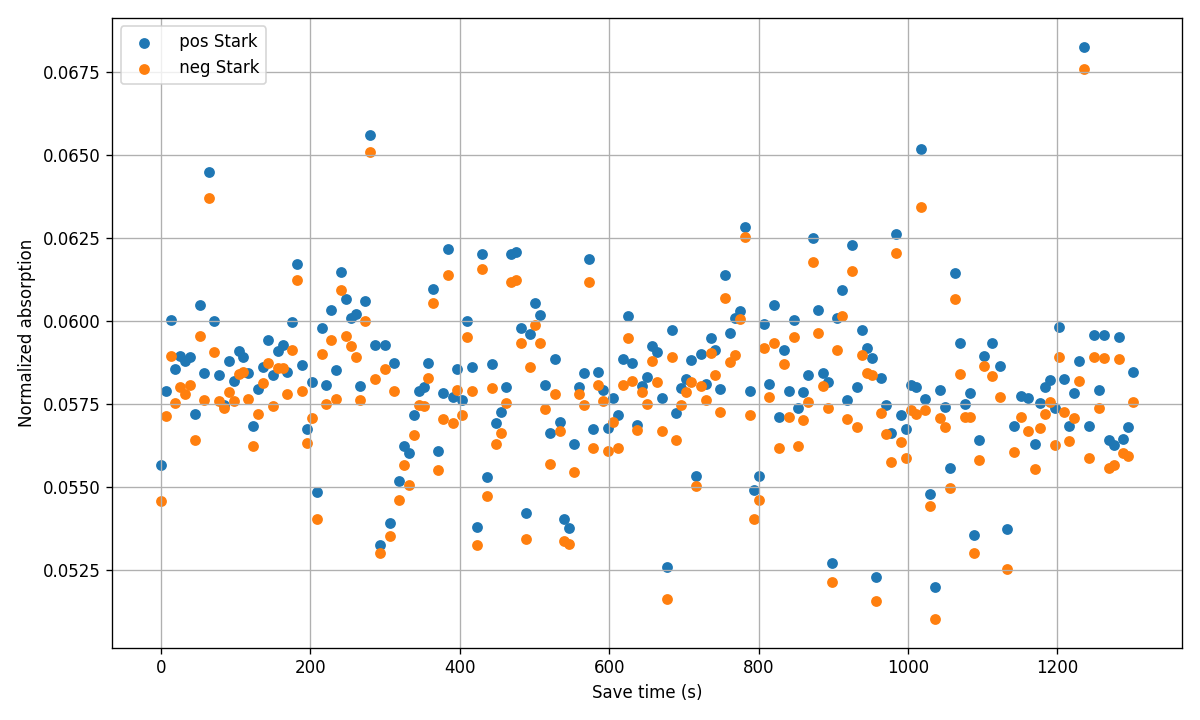

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PearsonRResult(statistic=0.9945744020212515, pvalue=1.266908127437659e-193)


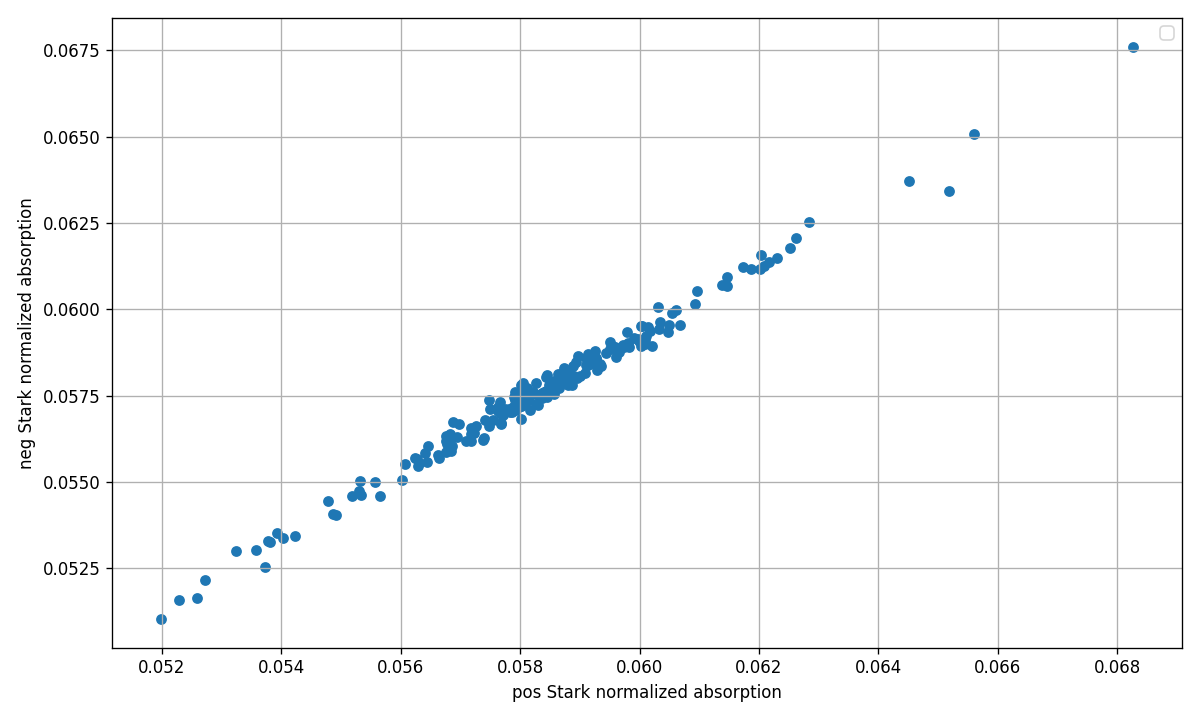

In [653]:
data = {
    "": (588222, 588418)
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["data_info"]["save_epoch_time"]-headers[0]["data_info"]["save_epoch_time"] for header in headers]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)

ax.set_xlabel(f"Save time (s)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    ys = (1-ratios)
    ax.scatter(ys[:, 0], ys[:,1], s = 30)
    rho = pearsonr(ys[:, 0], ys[:,1])
    print(rho)


ax.set_xlabel("pos Stark normalized absorption")
ax.set_ylabel("neg Stark normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()



## Fluctuations in Hole burning

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.004199764272051945
0.0042317337685411046


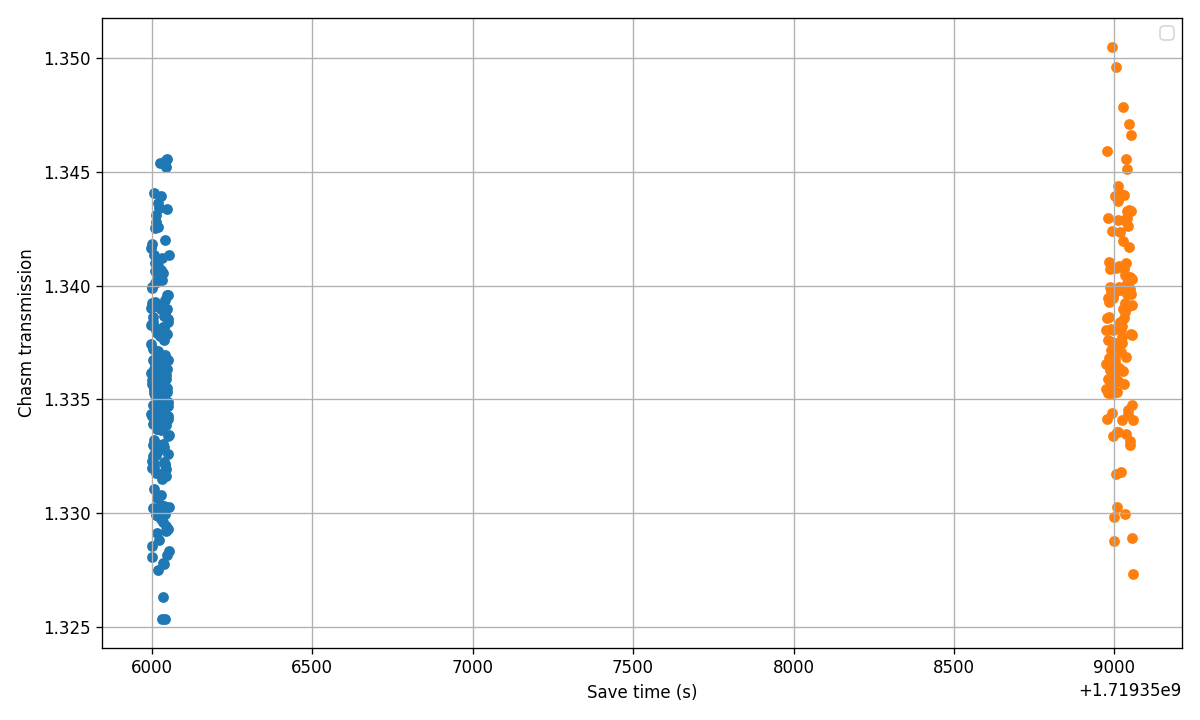

In [684]:
data = {
    # "chasm -> immediate detect": (588421, 588753)
    "chasm -> immediate detect -> wait -> detect": (589333, 589531),
    "3 decimal sync": (590121, 590239)
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ys = []
    xs = []
    for data_num in data_list:
        transmissions_avg, monitors_avg, headers = averaged_data_from_number(data_num)
        xs.append(headers["data_info"]["save_epoch_time"])
        ys.append((transmissions_avg["antihole"][0]/monitors_avg["antihole"][0]))
    print(np.std(ys))
    ax.scatter(xs, ys, s = 30)

ax.set_xlabel(f"Save time (s)")
ax.set_ylabel("Chasm transmission")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()